In [2]:
import pandas as pd
from tdmsdata import TdmsData
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import curve_fit   
from scipy.signal import fftconvolve
from scipy.stats import exponnorm
import statsmodels.api as sm
import os
import importlib
import doppler_shift_2024
import satlas2 as st
from scipy.constants import c

In [3]:
def read_tdms(folder_path, file, channel):
    TDMS = TdmsData(''.join([folder_path, file]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array, channel 1 = RAES, channel 3 = ID gated signal, channel 4 = ID gated bkg, channel 5 = nongated
    return raw_data

In [4]:
def create_df(raw_data):
    return pd.DataFrame({'Cycle No.': raw_data[:, 0], 'Time (sec)': raw_data[:, 1], 
                         'Laser Frequency (THz)': raw_data[:, 2], 'Approx Time': raw_data[:, 3], # Approx time is a timestamp for calib and interferometer 
                         'SDUMP': raw_data[:, 4], 'LE Probe': raw_data[:, 5]}) # SDUMP is dump current of PREVIOUS cycle (nA) and LE probe is beam energy (V) 

In [5]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift_2024)
    doppler_df = dataset.copy()
    freq = doppler_df['Laser Frequency (THz)']
    measured_voltage = doppler_df['LE Probe']
    shifted_freq = doppler_shift_2024.getshift(freq, isotope, measured_voltage)
    doppler_df['Laser Frequency (THz)'] = shifted_freq

    return doppler_df

In [6]:
def process_data(df):
    freq = 'Laser Frequency (THz)'
    bin_width = 50
    freq_range = (df[freq].max() - df[freq].min()) * 1e6 # MHz
    bins = int(np.ceil(freq_range / bin_width)) # number of bins will change to ensure bin worth is consistent 

    binned_df = (
            df
            .assign(Freq_bin=lambda df: pd.cut(df[freq], bins))
            .groupby('Freq_bin', observed=True) # separate counts for each bin and cycle
            .size()
            .reset_index(name='Count raw')
            .assign(Bin_center=lambda df: df['Freq_bin'].apply(lambda x: x.mid))
        )
    
    binned_df.columns = ['Freq bin', 'Count raw', 'Bin center']

    binned_df['Freq bin'] = binned_df['Freq bin'].astype('category')  # Match global dtype
    binned_df['Bin center'] = binned_df['Bin center'].astype(float)

    return binned_df

In [7]:
def thz_to_cm1(thz):
    c_cm_s = c * 100  # Convert to cm/s
    hz = thz * 1e12   # Convert THz to Hz
    return hz / c_cm_s

In [41]:
def get_weights():
    # sorted_117 = binned_df_117.sort_values(by='Count raw', ascending=False)
    # sorted_119 = binned_df_119.sort_values(by='Count raw', ascending=False)
    peak_avg_120_freq = 195.23738801574387 # THz

    peaks_119 = np.array([195.241065, 195.235395, 195.240175, 195.238975, 195.236690]) # THz, ascending by intensity
    peak_counts_119 = np.array([61110, 34583, 31413, 8392, 6341])
    weighted_center_119 = np.sum(peaks_119 * peak_counts_119) / np.sum(peak_counts_119)

    # total_counts_119 = binned_df_119['Count raw'].sum()
    # rel_intensity_119 = peak_counts_119/peak_counts_119.sum()
    # plt.plot(binned_df_119['Bin center'], binned_df_119['Count raw'])
    # plt.scatter(peaks_119, peak_counts_119, color='red')
    # plt.axvline(weighted_center_119)

    peaks_117 = np.array([195.235515, 195.241685, 195.240095, 195.238895, 195.236705])
    peak_counts_117 = np.array([60335, 48072, 44096, 15272, 9788])
    weighted_center_117 = np.sum(peaks_117 * peak_counts_117) / np.sum(peak_counts_117)


    # total_counts_117 = binned_df_117['Count raw'].sum()
    # rel_intensity_117 = peak_counts_117/peak_counts_117.sum()
    # plt.plot(binned_df_117['Bin center'], binned_df_117['Count raw'])
    # plt.scatter(peaks_117, peak_counts_117, color='red')
    # plt.axvline(weighted_center_117)

    print(weighted_center_117, weighted_center_119)
    shift_117 = (weighted_center_117 - peak_avg_120_freq)  
    shift_119 = (weighted_center_119 - peak_avg_120_freq)
    print(shift_117, shift_119)

    return weighted_center_117, weighted_center_119


In [42]:
def plot(binned_df_117, binned_df_119):
    freq_cm_117 = thz_to_cm1(binned_df_117['Bin center'])
    freq_cm_119 = thz_to_cm1(binned_df_119['Bin center'])

    weighted_center_117, weighted_center_119 = get_weights()

    weighted_center_117_cm = thz_to_cm1(weighted_center_117)
    weighted_center_119_cm = thz_to_cm1(weighted_center_119)

#     plot data in cm^-1
#     offset = 0#10000
#     plt.plot(freq_cm_117, binned_df_117['Count raw'], label='Sn117', color='red', 
#             linewidth = 2, alpha=0.7)#, marker = 'o', markerfacecolor='none')
#     plt.plot(freq_cm_119, binned_df_119['Count raw']+offset, label='Sn119', color='blue',
#             linewidth = 2, alpha=0.7)#, marker = 'o', markerfacecolor='none')
#     plt.axvline(6512.4183, linestyle='--', color='black', label='Reference (120Sn)')
#     plt.axvline(weighted_center_117_cm, linestyle = '--', color = 'red', alpha=0.7)
#     plt.axvline(weighted_center_119_cm, linestyle = '--', color = 'blue', alpha=0.7)    
    
#     plt.xlabel('Frequency (cm$^{-1}$)', fontsize=14)
#     plt.ylabel('Signal (arb. units)', fontsize=14)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)

#     plt.annotate('$^{117}$Sn$^-$', xy = (6512.565, 50000), fontsize=12, fontweight='bold')
#     plt.annotate('$^{119}$Sn$^-$', xy = (6512.55, 60000), fontsize=12, fontweight='bold')
# #     plt.savefig("odds_centroid.pdf", format="pdf", dpi=300, bbox_inches="tight")
#     plt.show()

    plt.plot(binned_df_117['Bin center'], binned_df_117['Count raw'], label='Sn117', color='red', 
            linewidth = 2, alpha=0.7)#, marker = 'o', markerfacecolor='none')
    plt.plot(binned_df_119['Bin center'], binned_df_119['Count raw'], label='Sn119', color='blue',
            linewidth = 2, alpha=0.7)#, marker = 'o', markerfacecolor='none')
    plt.axvline(195.23738801574387, linestyle='--', color='black', label='Sn120')
    plt.axvline(weighted_center_117, linestyle = '--', color = 'red', alpha=0.7)
    plt.axvline(weighted_center_119, linestyle = '--', color = 'blue', alpha=0.7)   
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    
#     plt.xlabel('Frequency (cm$^{-1}$)', fontsize=14)
#     plt.ylabel('Signal (arb. units)', fontsize=14)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)


    return 

195.23867912202994 195.2391661968852
0.0012911062860609945 0.0017781811413328796


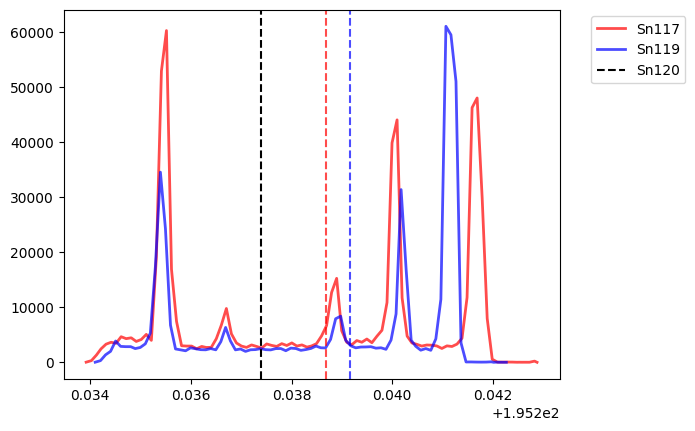

In [43]:
folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/odds/'
file = '20241022_2251_Sn_119_.48to.535_0.0003nms.tdms'
file2 = '20241023_2221_Sn-117_.485to.540_0.0003nms.tdms'
channel = 1

raw_data_119 = read_tdms(folder_path, file, channel)
data_df_119 = create_df(raw_data_119)
doppler_df_119 = doppler_shift_calc(data_df_119, 119)
binned_df_119 = process_data(doppler_df_119)

raw_data_117 = read_tdms(folder_path, file2, channel)
data_df_117 = create_df(raw_data_117)
doppler_df_117 = doppler_shift_calc(data_df_117, 117)
binned_df_117 = process_data(doppler_df_117)

plot(binned_df_117, binned_df_119)

# binned_df_117.to_pickle('binned_df_117.pkl')
# binned_df_119.to_pickle('binned_df_119.pkl')